# Credit Card Fraud Detection with Multi-feature DNN

# Overview
The purpose of this project is to use fully connected deep neural network (DNN) to detect the fraudulent credit card transactions in the multi-feature dataset. This is a classification problem, and the results by DNN are expected to show a multi-dimensional "decision boundary" that are hard to be defined by conventional classification techniques, e.g., SVM.

What's learned?
* With small number of anomalies, the anomaly "duplication" during training and using dropout layers does not lead to overfitting.


# Data
The dataset is based on kaggle's [credit card fraud detection](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv). According to the website, the dataset contains transactions occurred in two days made by credit cards in September 2013 by european cardholders. The positive class/frauds, 492 frauds out of 284,807 transactions, account for 0.172% of all transactions.

The credit card data features V1, V2, ..., V28 provided are numerical principle components (PC) obtained with principle component analysis (PCA) transformation. Therefore, each feature data is already normalized by the PC variance, and has zero mean and unit variance. The original features are not allowed due to confidentiality issues. The only features without PCA transformation are 'Time' (seconds elapsed between each transaction and the first transaction in the dataset) and 'Amount' (transaction Amount). Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.  

Since the PCA data are normalized, they can be worked directly as inputs for DNN. The 'Class' of 0 and 1 can be treated directly as the output using a sigmoid at the output layer.

Import necessary libraries:

In [17]:
import pandas as pd
from pandas import DataFrame as df
import math
import numpy as np
import time
from random import shuffle
from matplotlib import pyplot as plt
# ML tools
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TimeDistributed,Activation

Batch data generator for model training:

In [7]:
class KerasBatchGenerator:
    def __init__(self,data,batchsize,ndim,nsteps,skip_steps):
        self.data=data
        self.batchsize=batchsize
        self.current_idx=0
        self.nsteps=nsteps
        self.skip_steps = skip_steps
        self.ndim = ndim
    def generate(self,model):
        x = np.zeros((self.batchsize, self.ndim))            
        y = np.zeros((self.batchsize, 1))
        while True:
            for i in range(self.batchsize):
                x, y = self.data[self.current_idx:self.current_idx+self.nsteps,:-1], self.data[self.current_idx:self.current_idx+self.nsteps,-1]
                self.current_idx += self.skip_steps             
                yield x, y # yield returns a set of x,y values for model.fit_generator to perform batch training

Split data into train, valid, and test and create batches using KerasBatchGenerator:

In [8]:
# Define model parameters
batchsize = 30
nsteps = 5000 # number of samples in each batch
ndim = 29  # feature dimensions
hdim = 100 # hidden layer dimensions
hlayers= 20 # hidden layers
nepochs=50
dropoutRate = 0.2
datapath = 'data/'
data = pd.read_csv('data/creditcard.csv')
n = data.shape[0] # total sample size

# scale the "amount" column
scaler = MinMaxScaler(feature_range=(-1, 1))


scaler.fit(data.values[:,-2].reshape(-1,1))
amount_scaled = scaler.fit_transform(X=data.values[:,-2].reshape(-1,1))
data = np.concatenate([data.values[:,1:-2], amount_scaled, data.values[:,-1].reshape(-1,1)],axis=1) # drop the 1st time column and replace the scaled amount

data_ones  = data[[i==1 for i in data[:,-1]],:] # get ones 
data_zeros = data[[i==0 for i in data[:,-1]],:] # get zeros
#print(len(zeros[:round(0.8*len(zeros))]))

# shuffle data with ones into data with zeros
nrepeat=300
nz = len(data_ones)
train = np.concatenate([data[:round(0.8*n)],             np.repeat(data_ones[:round(0.8*nz)],nrepeat,axis=0)],axis=0)
valid = np.concatenate([data[round(0.8*n):round(0.9*n)], np.repeat(data_ones[round(0.8*nz):round(0.9*nz)],nrepeat,axis=0)],axis=0)
#test  = np.concatenate([data[round(0.9*n):],             np.repeat(data_ones[round(0.9*nz):],nrepeat,axis=0)],axis=0)
test  = data[round(0.9*n):]


np.random.shuffle(train), np.random.shuffle(valid)#, np.random.shuffle(test)

train_data_generator = KerasBatchGenerator(train, batchsize, ndim, nsteps, skip_steps=nsteps)
valid_data_generator = KerasBatchGenerator(valid, batchsize, ndim, nsteps, skip_steps=nsteps)

As shown in above codes, the anomalies duplicated (using `np.repeat`) since they only account for 0.17% of the total data which makes the model training very hard. The data is split into 80,10,10 percent for training, validation and testing. The anomaly duplication is only done in training and validation.

# Build Model
The model contains fully connected layers with dropout enabled to prevent overfitting:

In [283]:
# create the model according to the local paper

def build_model(ndim,hdim,hlayers,dropoutRate, datapath):
    model = Sequential()
    model.add(Dense(ndim, input_dim= ndim, kernel_initializer='glorot_normal', activation='relu'))
    for _ in range(hlayers-1):
        model.add(Dropout(dropoutRate))
        model.add(Dense(hdim, kernel_initializer='glorot_normal', activation='relu')) 
    model.add(Dense(1,kernel_initializer='glorot_normal', activation='sigmoid')) # determine the probability of anomaly 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
    model.summary()
    return model, checkpointer

# Train Model
Each epoch during the training are saved for the purpose to select the best model, let's start training:

In [284]:

# In order to reset_states for stateful_=True in the generater, 
# we need to pass the tensorflow session to the generator
last_epoch = 0 # set this to 0 if model never trained

model, checkpointer  = build_model(ndim, hdim, hlayers, dropoutRate, datapath)
model.fit_generator(train_data_generator.generate(model), len(train)//(batchsize*nsteps), epochs=last_epoch+nepochs,
                validation_data=valid_data_generator.generate(model), validation_steps=math.ceil(len(valid)/(batchsize*nsteps)),
                callbacks=[checkpointer],shuffle=True,initial_epoch=last_epoch)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_841 (Dense)            (None, 29)                870       
_________________________________________________________________
dropout_761 (Dropout)        (None, 29)                0         
_________________________________________________________________
dense_842 (Dense)            (None, 100)               3000      
_________________________________________________________________
dropout_762 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_843 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_763 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_844 (Dense)            (None, 100)               10100     
__________

As shown in the training, the accuracy approaches 1 and then becomes NAN as a result of exploding gradient when the change in weight is close to zero at the denominator.

# Single batch prediction
Use the best trained model to make the anomaly prediction for a number of prediction_samp samples

In [10]:
def predict(i_oldmodel,prediction_samp,data):
    model = keras.models.load_model('data/model-%s.hdf5'%i_oldmodel)
    y=[]
    for i in range(prediction_samp):
        curr_frame = data[i,:-1]   
        y.append(model.predict(curr_frame[np.newaxis,:]))                
    return y

In [13]:
prediction_samp=10000
y = np.asarray(predict(35,prediction_samp,test)).reshape(-1,1)
y_true = test[:prediction_samp,-1].reshape(-1,1)

total number of actual anomalies = 10
total number of actual anomalies predicted = 9.0
total number of anomalies predicted = 14
False positive rate = 0.35714285714285715


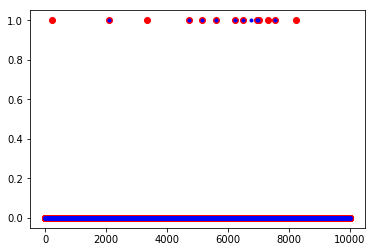

In [328]:
#plt.plot(range(0,prediction_samp),test_data,'b.')
y_test = np.array(y)
y_test[np.asarray([i>0.5 for i in y])] = 1
y_test[np.asarray([i<=0.5 for i in y])] = 0
#y[i<=0.5 for i in y]=0
plt.plot(range(0,prediction_samp),y_test,'ro')
npreda = np.count_nonzero(y_test)
i_preda = [i==1 for i in y_test] # predicted anomaly indices
nactual = sum(i==1 for i in y_true)
naccurate = npreda - abs(sum(y_test[i_preda]-y_true[i_preda])) 
print('total number of actual anomalies = '+ str(*nactual))
print('total number of actual anomalies predicted = '+str(naccurate))
print('total number of anomalies predicted = '+str(npreda))
print('False positive rate = '+str((npreda-naccurate)/npreda))
plt.plot(range(0,prediction_samp),y_true,'b.')


As shown in the above figure, with a test sample size of 10000, the algorithm captured 9 out of 10 actual anomalies (blue dots at ones). The False positive rate is 0.36, which is not too bad for such small number of anomalies.


<img src="roc1.png" alt="drawing" width="300"/>

Area Under Curve = 98.91


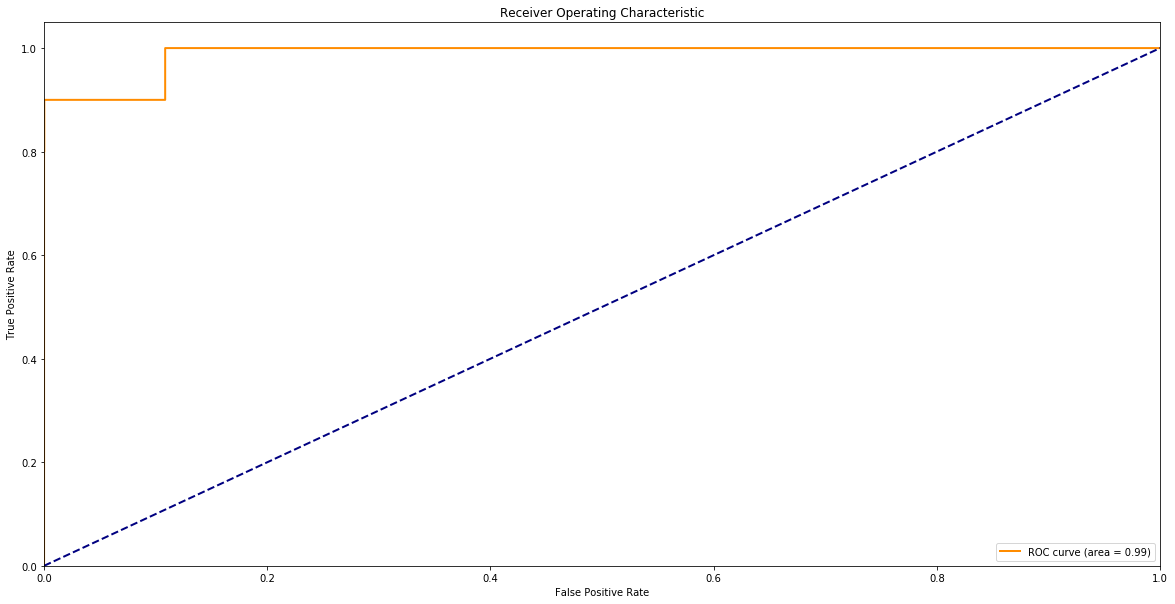

In [33]:
y_test = np.array(y)
y_true = test[:prediction_samp,-1].reshape(-1,1)
area_under_roc = sklearn.metrics.roc_auc_score(y_true, y_test) 
print('Area Under Curve = {:0.2f}'.format(area_under_roc*100))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_test)
roc_auc = sklearn.metrics.auc(fpr, tpr) # Area Under ROC Curve

#plt.figure()
lw = 2
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# ROC considers all thresholds of probabilities to plot the yellow curve
# suppose at FPR=0.1, the TPR=0.9
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

# Summary
The project shows that by duplicating the small samples of anomalies in the training process, the model can be well trained with DNN to capture the anomalies using multi-dimensional features. The false positive rate is low but I hope to reduce it further by tweaking the hyperparameters and adding more hidden layers.